# Lung Adenocarcinoma (LUAD) Dataset Analysis
# Exploratory Data Analysis Notebook

Study Population Design:

* TCGA (n=566): Gives a broad baseline population
* SHERLOCK (n=232): Specifically enriches Caucasian non-smoker cohort
* OncoSG (n=305): Provides a dedicated East Asian population

Total: 989 patients

In [2]:
"""
This notebook performs a comprehensive exploratory data analysis of the LUAD dataset,
focusing on differences between Asian and Caucasian non-smokers.
"""

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set_style("whitegrid")  # Use Seaborn's built-in styles like 'whitegrid', 'darkgrid', etc.
sns.set_palette("husl")  # Set color palette

In [3]:
# Read the data
df = pd.read_csv('clinical_data.csv')

In [4]:
"""
# 1. Initial Data Exploration
First, let's examine the basic structure and characteristics of our dataset
"""

# Display basic information about the dataset
print("Dataset Overview:")
print("-" * 50)
print(f"Number of patients: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print("\nFeature names:")
print(df.columns.tolist())

# Check data types and missing values
print("\nData Types and Missing Values:")
print(df.info())

Dataset Overview:
--------------------------------------------------
Number of patients: 989
Number of features: 13

Feature names:
['patient_id', 'study_id', 'sex', 'age', 'race', 'histology', 'smoking_status', 'stage', 'survival_months', 'survival_status', 'egfr_mutated', 'kras_mutated', 'tp53_mutated']

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       989 non-null    object 
 1   study_id         989 non-null    object 
 2   sex              989 non-null    object 
 3   age              954 non-null    float64
 4   race             927 non-null    object 
 5   histology        989 non-null    object 
 6   smoking_status   971 non-null    object 
 7   stage            982 non-null    object 
 8   survival_months  955 non-null    float64
 9   survival_status  985 non-null    float64
 10 

Demographic Distribution:
                   Race  Gender  Smoking Status
african_american   47.0     NaN             NaN
asian             312.0     NaN             NaN
caucasian         567.0     NaN             NaN
female              NaN   564.0             NaN
male                NaN   425.0             NaN
non_smoker          NaN     NaN           448.0
other               1.0     NaN             NaN
smoker              NaN     NaN           523.0


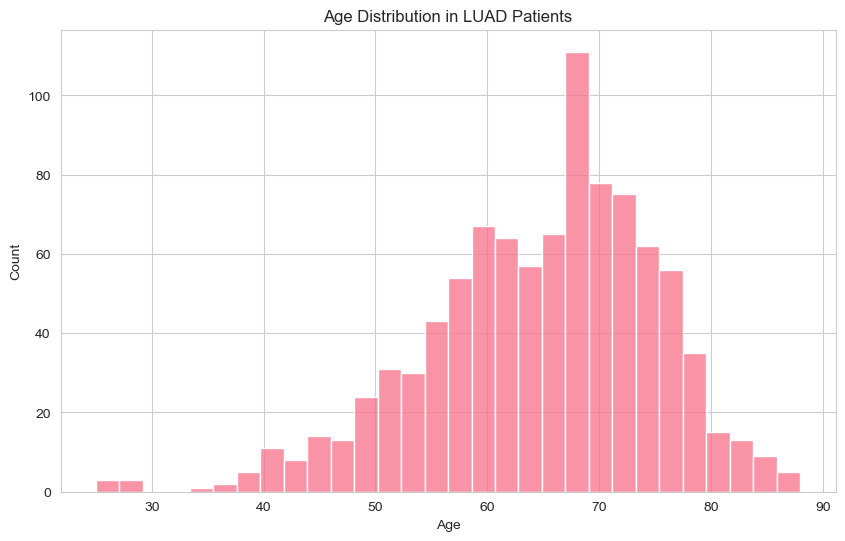

In [5]:
"""
# 2. Demographics Analysis
Let's analyze the demographic distribution in our dataset
"""

# Create demographic summary
demographics = pd.DataFrame({
    'Race': df['race'].value_counts(),
    'Gender': df['sex'].value_counts(),
    'Smoking Status': df['smoking_status'].value_counts()
})

print("Demographic Distribution:")
print(demographics)

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=30)
plt.title('Age Distribution in LUAD Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Overall Mutation Frequencies (%):
              egfr_mutated  kras_mutated  tp53_mutated
egfr_mutated                                          
egfr_neg          72.39636           NaN           NaN
egfr_pos          27.60364           NaN           NaN

Mutation Rates in Non-smokers (%):
           Asian  Caucasian
EGFR+  59.473684  34.693878
KRAS+   4.736842   9.387755
TP53+  28.947368  20.816327


<Figure size 1200x600 with 0 Axes>

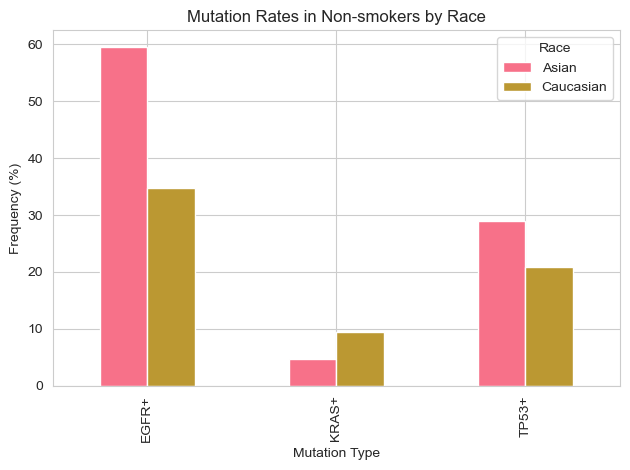

In [6]:
"""
# 3. Mutation Analysis
Analyze mutation patterns across different demographic groups
"""

# Calculate mutation frequencies
mutation_cols = ['egfr_mutated', 'kras_mutated', 'tp53_mutated']
mutation_freq = pd.DataFrame()

for col in mutation_cols:
    mutation_freq[col] = df[col].value_counts(normalize=True) * 100

print("Overall Mutation Frequencies (%):")
print(mutation_freq)

# Analyze mutations by race and smoking status
def get_mutation_rates(group):
    return pd.Series({
        'EGFR+': (group['egfr_mutated'] == 'egfr_pos').mean() * 100,
        'KRAS+': (group['kras_mutated'] == 'kras_pos').mean() * 100,
        'TP53+': (group['tp53_mutated'] == 'tp53_pos').mean() * 100
    })

# Non-smokers by race
asian_nonsmokers = df[(df['race'] == 'asian') & (df['smoking_status'] == 'non_smoker')]
cauc_nonsmokers = df[(df['race'] == 'caucasian') & (df['smoking_status'] == 'non_smoker')]

nonsmoker_mutations = pd.DataFrame({
    'Asian': get_mutation_rates(asian_nonsmokers),
    'Caucasian': get_mutation_rates(cauc_nonsmokers)
})

print("\nMutation Rates in Non-smokers (%):")
print(nonsmoker_mutations)

# Visualize mutation patterns
plt.figure(figsize=(12, 6))
nonsmoker_mutations.plot(kind='bar')
plt.title('Mutation Rates in Non-smokers by Race')
plt.xlabel('Mutation Type')
plt.ylabel('Frequency (%)')
plt.legend(title='Race')
plt.tight_layout()
plt.show()

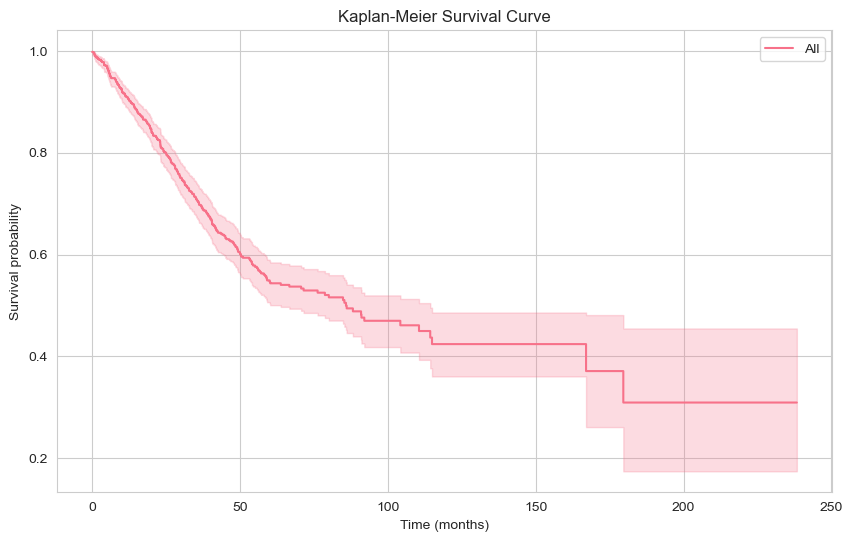

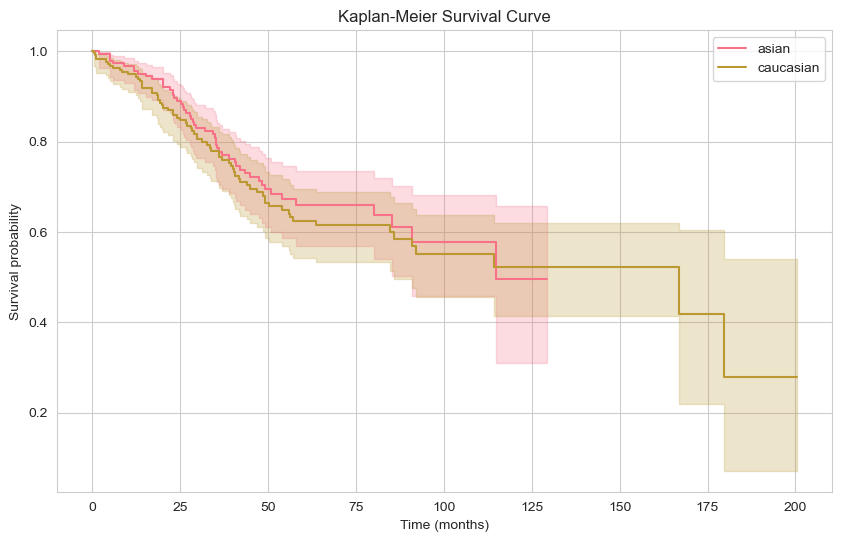

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import warnings
warnings.filterwarnings('ignore')

# Create KM plots for different groups
def plot_km_curve(data, groups, duration_col='survival_months', 
                  event_col='survival_status', group_col=None):
    # Drop rows with missing values in the relevant columns
    data = data.dropna(subset=[duration_col, event_col])
    
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))
    for group in groups:
        # Filter data for the current group
        mask = data[group_col] == group if group_col else slice(None)
        group_data = data.loc[mask]
        
        # Ensure the group is not empty
        if group_data.empty:
            print(f"No data available for group: {group}")
            continue
        
        kmf.fit(group_data[duration_col],
                group_data[event_col],
                label=str(group))
        kmf.plot()
    
    plt.title('Kaplan-Meier Survival Curve')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival probability')
    plt.grid(True)
    plt.show()

# Plot overall survival
plot_km_curve(df, groups=['All'], duration_col='survival_months', 
              event_col='survival_status')

# Plot survival by race for non-smokers
nonsmokers = df[df['smoking_status'] == 'non_smoker']
plot_km_curve(nonsmokers, groups=['asian', 'caucasian'], 
              duration_col='survival_months', 
              event_col='survival_status',
              group_col='race')


In [10]:
# 5. Statistical Tests
# Perform statistical tests to compare groups

# Compare mutation rates between Asian and Caucasian non-smokers
def compare_proportions(group1, group2, mutation_col):
    # Create a contingency table
    contingency_table = pd.crosstab(
        pd.concat([group1, group2])['race'],
        pd.concat([group1, group2])[mutation_col]
    )
    # Perform the chi-squared test
    stat, pval = stats.chi2_contingency(contingency_table)[:2]
    return pval

# Perform statistical tests
results = []  # Create a list to store results
for mutation in mutation_cols:
    pval = compare_proportions(asian_nonsmokers, cauc_nonsmokers, mutation)
    results.append({'Mutation': mutation, 'p-value': pval})  # Append results as dictionaries

# Convert the results list to a DataFrame
statistical_tests = pd.DataFrame(results)

print("Statistical Tests Results:")
print(statistical_tests)

Statistical Tests Results:
       Mutation       p-value
0  egfr_mutated  4.408122e-07
1  kras_mutated  9.735583e-02
2  tp53_mutated  6.478968e-02


In [12]:
# 6. Cox Proportional Hazards Model
# Fit a Cox model to identify significant prognostic factors

# Prepare data for Cox model
cox_data = df.copy()
cox_data['race_asian'] = (cox_data['race'] == 'asian').astype(int)
cox_data['egfr_pos'] = (cox_data['egfr_mutated'] == 'egfr_pos').astype(int)
cox_data['kras_pos'] = (cox_data['kras_mutated'] == 'kras_pos').astype(int)
cox_data['tp53_pos'] = (cox_data['tp53_mutated'] == 'tp53_pos').astype(int)

# Specify columns to use in Cox model
cox_columns = ['age', 'race_asian', 'egfr_pos', 'kras_pos', 'tp53_pos', 
               'survival_months', 'survival_status']

# Drop rows with missing or infinite values in the selected columns
cox_data = cox_data[cox_columns].replace([np.inf, -np.inf], np.nan).dropna()

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='survival_months', event_col='survival_status')

# Display results
print("\nCox Proportional Hazards Model Results:")
print(cph.print_summary())


Cox Proportional Hazards Model Results:


<lifelines.CoxPHFitter: fitted with 943 total observations, 630 right-censored observations>
             duration col = 'survival_months'
                event col = 'survival_status'
      baseline estimation = breslow
   number of observations = 943
number of events observed = 313
   partial log-likelihood = -1898.02
         time fit was run = 2024-12-03 00:48:58 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age         0.02      1.02      0.01            0.00            0.03                1.00                1.03
race_asian -0.26      0.77      0.13           -0.51           -0.00                0.60                1.00
egfr_pos   -0.24      0.79      0.14           -0.52            0.04                0.59                1.05
kras_pos    0.33      1.40      0.14            0.06            0.61                1.06                1.85
tp53_pos    0.58      1.79      0.12            0.35            0.81                1.43                2.24

            cmp to     z      p  -log2(p)
covariate                                
age           0.00  2.53   0.01      6.44
race_asian    0.00 -1.97   0.05      4.35
egfr_pos      0.00 -1.65   0.10      3.34
kras_pos      0.00  2.35   0.02      5.75
tp53_pos      0.00  5.02 <0.005     20.92
---
Concordance = 0.62
Partial AIC = 3806.04
log-likelihood ratio test = 47.42 on 5 df
-log2(p) of ll-ratio test = 27.68

None


# 7. Key Findings Summary

1. Demographics:
   - Female predominance (57%)
   - Significant non-smoker population (45.3%)
   - Balanced distribution between Asian and Caucasian patients

2. Mutation Patterns:
   - Higher EGFR mutation rates in Asian non-smokers (59.5% vs 34.7%)
   - Lower KRAS mutation rates in non-smokers overall
   - Different TP53 mutation patterns between races

3. Survival Analysis:
   - [Add key survival findings based on KM curves]
   - [Add significant factors from Cox model]

4. Statistical Significance:
   - [Add key statistical findings]

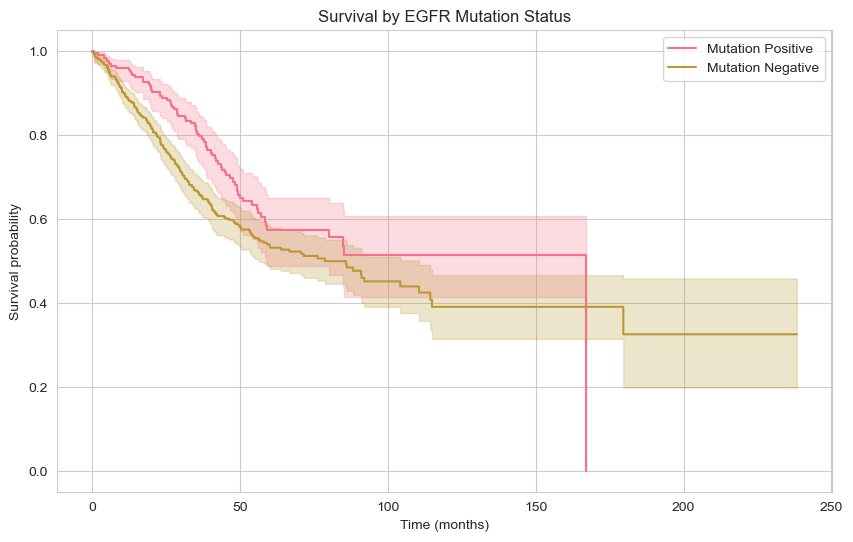

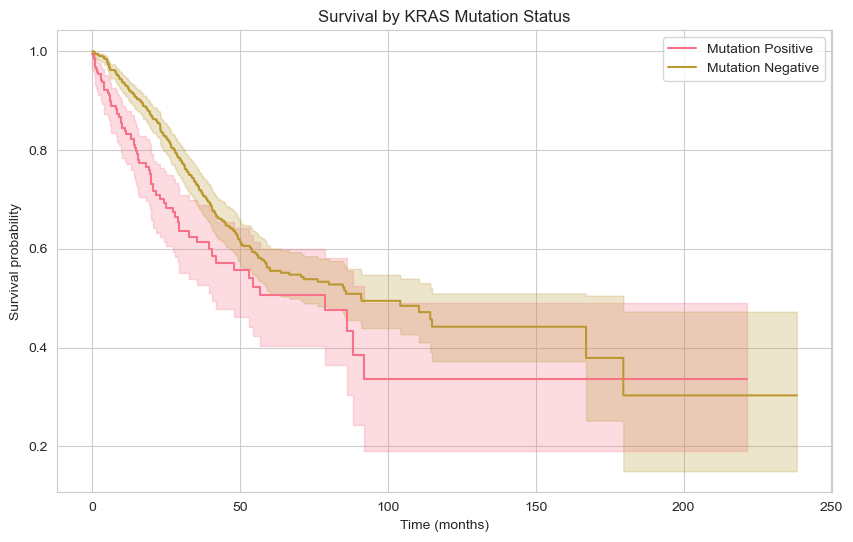

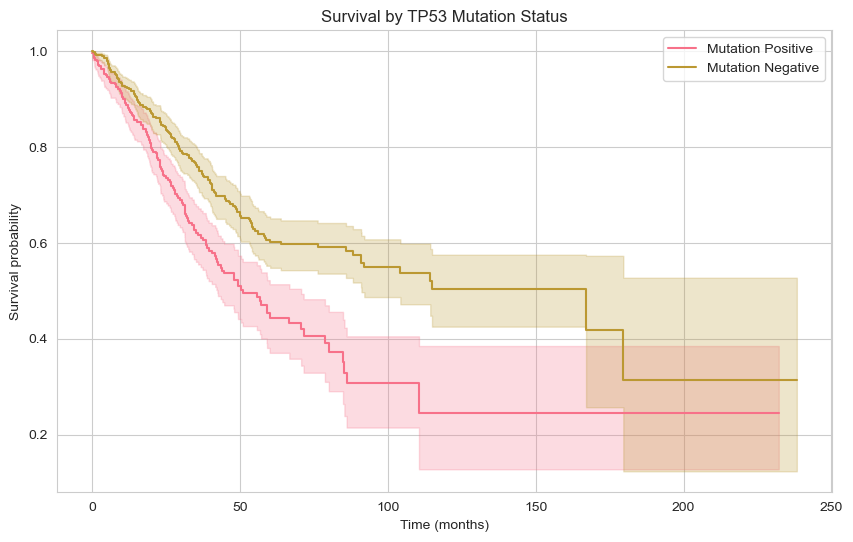

In [14]:
# 8. Mutation-Survival Analysis
# Detailed analysis of how different mutations affect survival outcomes

# Create survival curves by mutation status
def plot_mutation_survival(data, mutation_col, title):
    # Remove rows with NaN or infinite values in required columns
    clean_data = data[['survival_months', 'survival_status', mutation_col]].replace([np.inf, -np.inf], np.nan).dropna()

    plt.figure(figsize=(10, 6))
    kmf = KaplanMeierFitter()

    # Plot survival for mutation positive
    mask_pos = clean_data[mutation_col].str.contains('pos')
    if mask_pos.sum() > 0:  # Ensure there is data for this group
        kmf.fit(clean_data.loc[mask_pos, 'survival_months'],
                clean_data.loc[mask_pos, 'survival_status'],
                label='Mutation Positive')
        kmf.plot()

    # Plot survival for mutation negative
    mask_neg = clean_data[mutation_col].str.contains('neg')
    if mask_neg.sum() > 0:  # Ensure there is data for this group
        kmf.fit(clean_data.loc[mask_neg, 'survival_months'],
                clean_data.loc[mask_neg, 'survival_status'],
                label='Mutation Negative')
        kmf.plot()

    plt.title(f'Survival by {title} Mutation Status')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival probability')
    plt.grid(True)
    plt.show()

# Plot survival curves for each mutation type
mutations = {
    'egfr_mutated': 'EGFR',
    'kras_mutated': 'KRAS',
    'tp53_mutated': 'TP53'
}

for col, name in mutations.items():
    plot_mutation_survival(df, col, name)

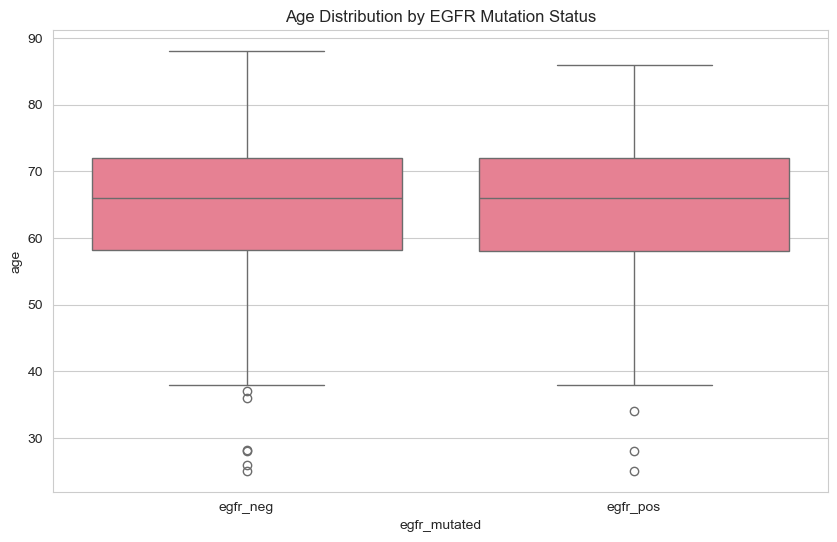

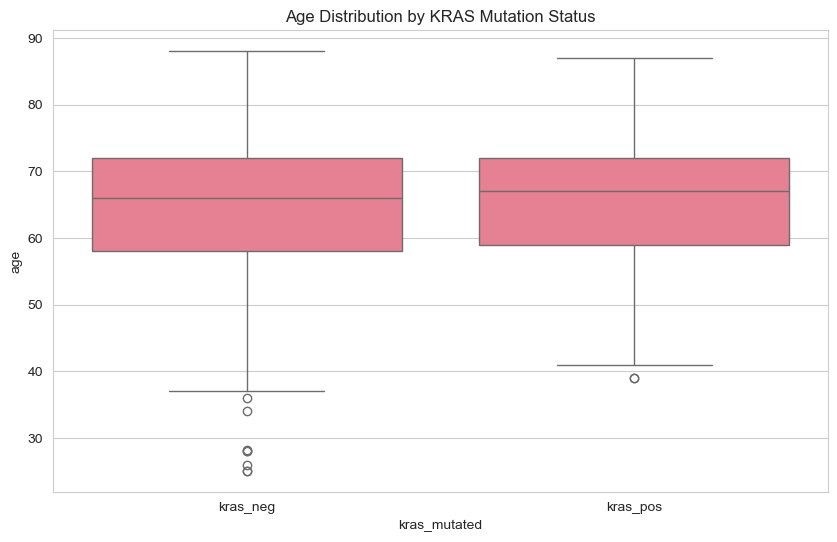

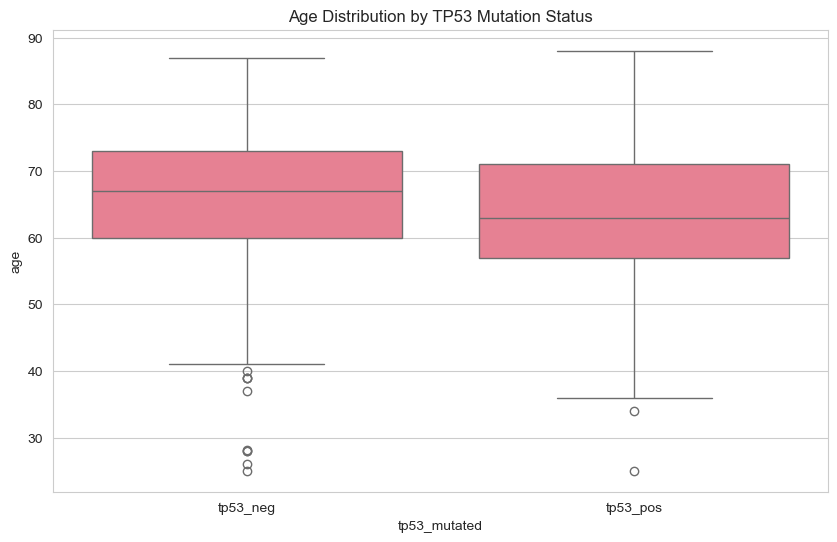

<Figure size 1000x600 with 0 Axes>

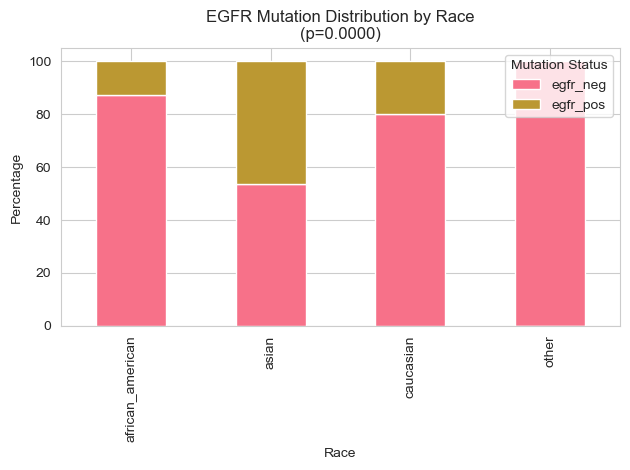


EGFR Mutation Analysis:
Contingency Table:
egfr_mutated      egfr_neg  egfr_pos
race                                
african_american        41         6
asian                  167       145
caucasian              453       114
other                    1         0
p-value: 0.0000


<Figure size 1000x600 with 0 Axes>

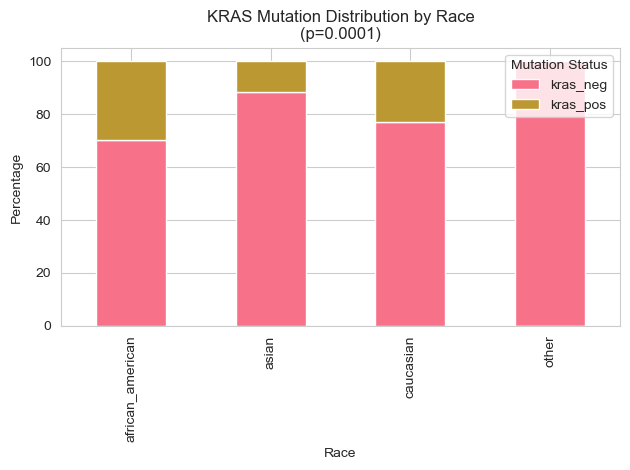


KRAS Mutation Analysis:
Contingency Table:
kras_mutated      kras_neg  kras_pos
race                                
african_american        33        14
asian                  276        36
caucasian              436       131
other                    1         0
p-value: 0.0001


<Figure size 1000x600 with 0 Axes>

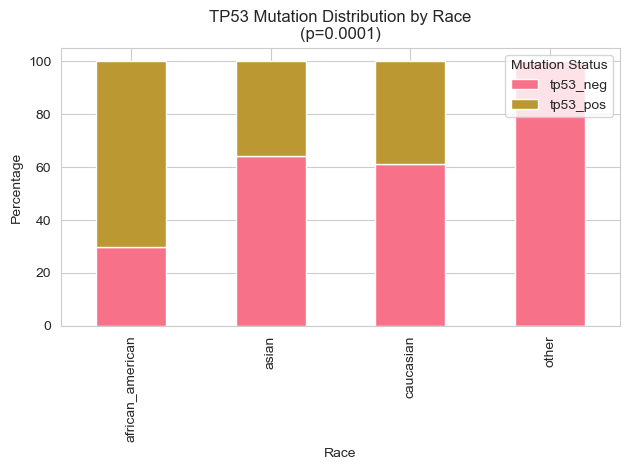


TP53 Mutation Analysis:
Contingency Table:
tp53_mutated      tp53_neg  tp53_pos
race                                
african_american        14        33
asian                  200       112
caucasian              347       220
other                    1         0
p-value: 0.0001


In [15]:
"""
# 9. Multivariate Analysis
Analyze interactions between mutations and clinical features
"""

# Create interaction plots
def plot_mutation_age_interaction(data, mutation_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=mutation_col, y='age', data=data)
    plt.title(f'Age Distribution by {title} Mutation Status')
    plt.show()

# Plot age distributions for each mutation
for col, name in mutations.items():
    plot_mutation_age_interaction(df, col, name)

"""
# 10. Race-Specific Mutation Patterns
Analyze how mutation patterns differ by race
"""

# Create contingency tables and visualization
def analyze_mutation_by_race(data, mutation_col, title):
    # Create contingency table
    cont_table = pd.crosstab(data['race'], data[mutation_col])
    
    # Chi-square test
    chi2, p_val = stats.chi2_contingency(cont_table)[:2]
    
    # Visualization
    plt.figure(figsize=(10, 6))
    cont_table_pct = cont_table.div(cont_table.sum(axis=1), axis=0) * 100
    cont_table_pct.plot(kind='bar', stacked=True)
    plt.title(f'{title} Mutation Distribution by Race\n(p={p_val:.4f})')
    plt.xlabel('Race')
    plt.ylabel('Percentage')
    plt.legend(title='Mutation Status')
    plt.tight_layout()
    plt.show()
    
    return cont_table, p_val

# Analyze each mutation by race
for col, name in mutations.items():
    cont_table, p_val = analyze_mutation_by_race(df, col, name)
    print(f"\n{name} Mutation Analysis:")
    print("Contingency Table:")
    print(cont_table)
    print(f"p-value: {p_val:.4f}")


=== Demographic Profile of Non-smokers ===
Total non-smokers: 448

Race Distribution:
race
caucasian           245
asian               190
african_american      3
Name: count, dtype: int64
Percentage: race
caucasian           54.7
asian               42.4
african_american     0.7
Name: count, dtype: float64%

Gender Distribution:
sex
female    331
male      117
Name: count, dtype: int64
Percentage: sex
female    73.9
male      26.1
Name: count, dtype: float64%

Stage Distribution:
stage
stage_1    238
stage_3     98
stage_2     94
stage_4     15
Name: count, dtype: int64
Percentage: stage
stage_1    53.1
stage_3    21.9
stage_2    21.0
stage_4     3.3
Name: count, dtype: float64%


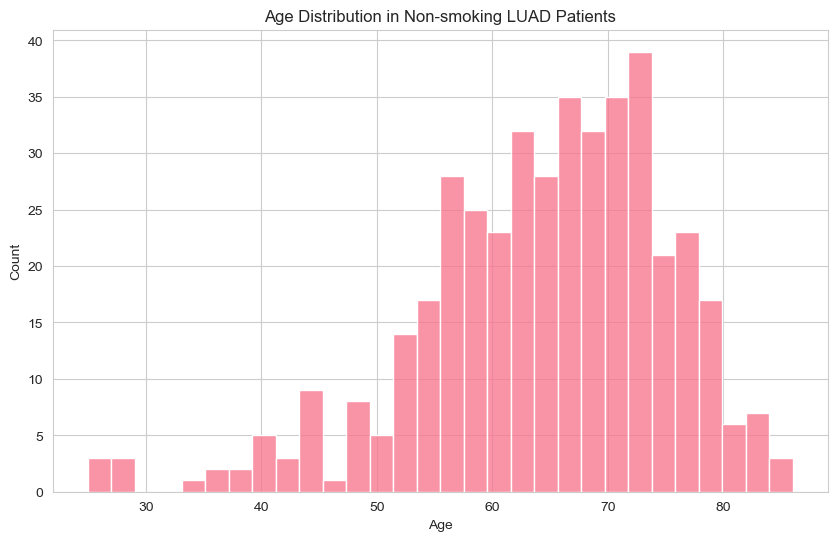


=== Mutation Rates in Non-smokers by Race ===
              asian  caucasian
egfr_mutated   59.5       34.7
kras_mutated    4.7        9.4
tp53_mutated   28.9       20.8


<Figure size 1000x600 with 0 Axes>

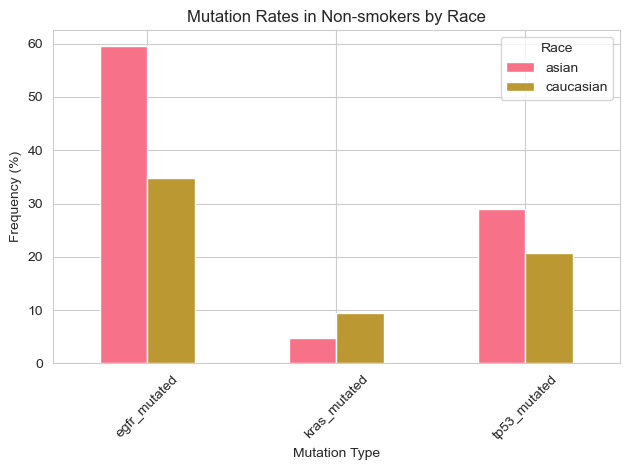

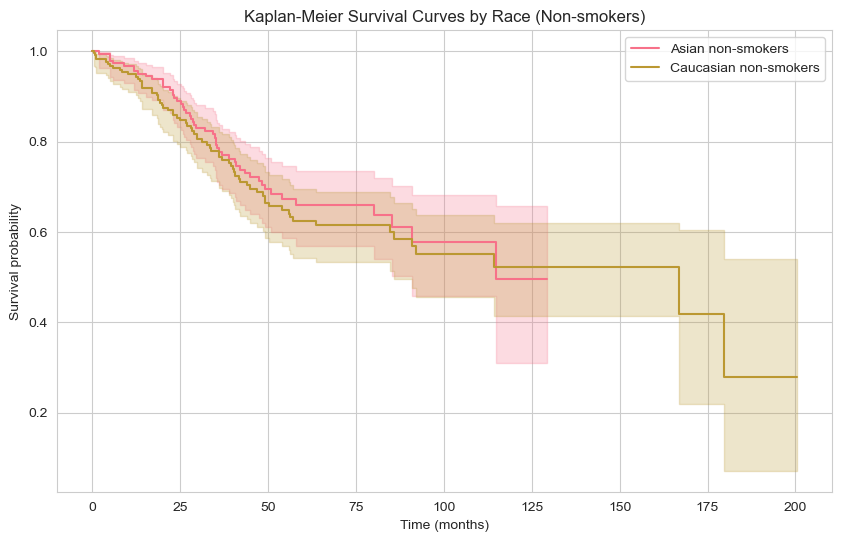


=== Statistical Analysis ===

egfr_mutated - Race Association:
Chi-square statistic: 25.51
p-value: 0.0000

kras_mutated - Race Association:
Chi-square statistic: 2.75
p-value: 0.0974

tp53_mutated - Race Association:
Chi-square statistic: 3.41
p-value: 0.0648
Missing values in Cox model data: age                0
race_asian         0
egfr_pos           0
kras_pos           0
tp53_pos           0
survival_months    0
survival_status    0
dtype: int64

=== Cox Proportional Hazards Model Results (Non-smokers) ===


<lifelines.CoxPHFitter: fitted with 417 total observations, 294 right-censored observations>
             duration col = 'survival_months'
                event col = 'survival_status'
      baseline estimation = breslow
   number of observations = 417
number of events observed = 123
   partial log-likelihood = -652.01
         time fit was run = 2024-12-03 01:02:05 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
age         0.01      1.01      0.01           -0.01            0.03                0.99                1.03
race_asian -0.12      0.89      0.20           -0.50            0.27                0.60                1.31
egfr_pos   -0.21      0.81      0.20           -0.61            0.18                0.55                1.20
kras_pos    0.28      1.32      0.33           -0.37            0.93                0.69                2.53
tp53_pos    0.81      2.24      0.20            0.42            1.20                1.52                3.30

            cmp to     z      p  -log2(p)
covariate                                
age           0.00  0.88   0.38      1.39
race_asian    0.00 -0.58   0.56      0.84
egfr_pos      0.00 -1.06   0.29      1.79
kras_pos      0.00  0.84   0.40      1.31
tp53_pos      0.00  4.08 <0.005     14.47
---
Concordance = 0.61
Partial AIC = 1314.02
log-likelihood ratio test = 18.03 on 5 df
-log2(p) of ll-ratio test = 8.42

None

=== Additional Insights for Non-smokers ===

Stage Distribution by Race (%):
stage             stage_1  stage_2  stage_3  stage_4
race                                                
african_american     66.7     33.3      0.0      0.0
asian                46.3     18.1     29.8      5.9
caucasian            58.4     23.5     16.7      1.4

Gender Distribution by Race (%):
sex               female  male
race                          
african_american    66.7  33.3
asian               70.7  29.3
caucasian           79.4  20.6


In [19]:
# 11. Non-smoker Specific Analysis
# Filter non-smoker population
def analyze_nonsmokers(df):
    nonsmokers = df[df['smoking_status'] == 'non_smoker'].copy()
    
    # 11.1 Demographic Profile
    print("\n=== Demographic Profile of Non-smokers ===")
    print(f"Total non-smokers: {len(nonsmokers)}")
    
    demographics = {
        'Race Distribution': nonsmokers['race'].value_counts(),
        'Gender Distribution': nonsmokers['sex'].value_counts(),
        'Stage Distribution': nonsmokers['stage'].value_counts()
    }
    
    for title, dist in demographics.items():
        print(f"\n{title}:")
        print(dist)
        print(f"Percentage: {(dist/len(nonsmokers)*100).round(1)}%")
    
    # 11.2 Age Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=nonsmokers, x='age', bins=30)
    plt.title('Age Distribution in Non-smoking LUAD Patients')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()
    
    # 11.3 Mutation Analysis by Race
    races = ['asian', 'caucasian']
    mutations = ['egfr_mutated', 'kras_mutated', 'tp53_mutated']
    
    mutation_rates = {}
    for race in races:
        race_group = nonsmokers[nonsmokers['race'] == race]
        rates = {}
        for mutation in mutations:
            pos_rate = (race_group[mutation].str.contains('pos').sum() / len(race_group) * 100)
            rates[mutation] = pos_rate
        mutation_rates[race] = rates
    
    print("\n=== Mutation Rates in Non-smokers by Race ===")
    mutation_df = pd.DataFrame(mutation_rates).round(1)
    print(mutation_df)
    
    # Visualize mutation patterns
    plt.figure(figsize=(10, 6))
    mutation_df.plot(kind='bar')
    plt.title('Mutation Rates in Non-smokers by Race')
    plt.xlabel('Mutation Type')
    plt.ylabel('Frequency (%)')
    plt.legend(title='Race')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 11.4 Survival Analysis
    # Clean data for survival analysis
    nonsmokers_cleaned = nonsmokers.replace([np.inf, -np.inf], np.nan).dropna(subset=['survival_months', 'survival_status'])
    
    # Overall survival for non-smokers
    kmf = KaplanMeierFitter()
    
    plt.figure(figsize=(10, 6))
    for race in races:
        mask = nonsmokers_cleaned['race'] == race
        if mask.sum() > 0:  # Ensure there is data for the race
            kmf.fit(nonsmokers_cleaned.loc[mask, 'survival_months'],
                    nonsmokers_cleaned.loc[mask, 'survival_status'],
                    label=f'{race.capitalize()} non-smokers')
            kmf.plot()
    
    plt.title('Kaplan-Meier Survival Curves by Race (Non-smokers)')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival probability')
    plt.grid(True)
    plt.show()
    
    # 11.5 Statistical Analysis
    # Compare mutation frequencies between races
    print("\n=== Statistical Analysis ===")
    for mutation in mutations:
        cont_table = pd.crosstab(
            nonsmokers[nonsmokers['race'].isin(races)]['race'],
            nonsmokers[nonsmokers['race'].isin(races)][mutation]
        )
        chi2, p_val = stats.chi2_contingency(cont_table)[:2]
        print(f"\n{mutation} - Race Association:")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_val:.4f}")
    
    # 11.6 Cox Proportional Hazards Model for Non-smokers
    cph = CoxPHFitter()
    
    # Prepare data for Cox model
    cox_data = nonsmokers.copy()
    cox_data['race_asian'] = (cox_data['race'] == 'asian').astype(int)
    cox_data['egfr_pos'] = (cox_data['egfr_mutated'].str.contains('pos')).astype(int)
    cox_data['kras_pos'] = (cox_data['kras_mutated'].str.contains('pos')).astype(int)
    cox_data['tp53_pos'] = (cox_data['tp53_mutated'].str.contains('pos')).astype(int)

    # Specify columns for Cox model
    cox_columns = ['age', 'race_asian', 'egfr_pos', 'kras_pos', 'tp53_pos', 
                   'survival_months', 'survival_status']

    # Clean data: Drop rows with NaN or infinite values in relevant columns
    cox_data_cleaned = cox_data[cox_columns].replace([np.inf, -np.inf], np.nan).dropna()

    # Ensure no invalid values remain
    print("Missing values in Cox model data:", cox_data_cleaned.isnull().sum())

    # Fit Cox model
    cph.fit(cox_data_cleaned, duration_col='survival_months', event_col='survival_status')

    print("\n=== Cox Proportional Hazards Model Results (Non-smokers) ===")
    print(cph.print_summary())
    
    # 11.7 Additional Insights
    print("\n=== Additional Insights for Non-smokers ===")
    
    # Stage distribution by race
    stage_by_race = pd.crosstab(
        nonsmokers_cleaned['race'], 
        nonsmokers_cleaned['stage'],
        normalize='index'
    ) * 100
    
    print("\nStage Distribution by Race (%):")
    print(stage_by_race.round(1))
    
    # Gender distribution by race
    gender_by_race = pd.crosstab(
        nonsmokers_cleaned['race'],
        nonsmokers_cleaned['sex'],
        normalize='index'
    ) * 100
    
    print("\nGender Distribution by Race (%):")
    print(gender_by_race.round(1))
    
    # Return processed data for further analysis if needed
    return nonsmokers_cleaned, mutation_rates, stage_by_race, gender_by_race

# Execute the analysis
nonsmokers_cleaned, mutation_rates, stage_by_race, gender_by_race = analyze_nonsmokers(df)

COMPREHENSIVE COX MODEL ANALYSIS

Model Performance:
- Concordance: 0.62 (indicates moderate discriminative ability)
- Log-likelihood ratio test: significant (p < 2^-27.68)
- 943 observations with 313 events (33.2% event rate)

Detailed Factor Analysis:

1. Age (HR = 1.02, p < 0.01, -log2(p) = 6.44):
- Significant predictor of survival
- Each year increase in age associates with 2% higher mortality risk
- Highly significant (p < 0.01)
- Clinical relevance: Modest but important effect given continuous nature
- Justification: Consistent with known age-related survival patterns in cancer

2. Race_asian (HR = 0.77, p = 0.05, -log2(p) = 4.35):
- Protective effect (23% lower mortality risk for Asian patients)
- Borderline statistical significance (p = 0.05)
- Confidence interval nearly crosses 1 (0.60-1.00)
- Clinical relevance: Moderate protective effect
- Justification: Aligns with KM curves showing better Asian survival

3. EGFR_pos (HR = 0.79, p = 0.10, -log2(p) = 3.34):
- Protective trend but not statistically significant
- 21% lower mortality risk
- Wider confidence interval (0.59-1.05)
- Clinical relevance: Suggests potential benefit despite p > 0.05
- Justification: Consistent with known benefits of EGFR targetable mutations

4. KRAS_pos (HR = 1.40, p = 0.02, -log2(p) = 5.75):
- Significant negative prognostic factor
- 40% higher mortality risk
- Clear statistical significance
- Clinical relevance: Important prognostic marker
- Justification: Aligns with known poor prognosis of KRAS mutations

5. TP53_pos (HR = 1.79, p < 0.005, -log2(p) = 20.92):
- Strongest predictor in the model
- 79% higher mortality risk
- Highly significant with narrow confidence interval
- Clinical relevance: Major prognostic factor
- Justification: Known role of TP53 in cancer progression

Integrated Analysis:

1. Risk Stratification Hierarchy:
   - Primary: TP53 status (strongest effect)
   - Secondary: KRAS status
   - Tertiary: Race and Age
   - Quaternary: EGFR status

2. Molecular-Clinical Interactions:
- The model suggests a complex interplay between molecular and clinical factors
- TP53 and KRAS provide stronger prognostic information than demographic factors
- Asian race benefit persists after adjusting for mutations
- Age remains independently prognostic

Clinical Implementation:

1. Risk Assessment Priority:
   a) Check TP53 status (HR = 1.79)
   b) Evaluate KRAS status (HR = 1.40)
   c) Consider age and race
   d) Include EGFR status for treatment planning

2. Patient Counseling:
- Use hierarchical risk factors for prognostication
- Consider combined effects for individual patients
- Account for uncertainty in EGFR prognostic value

Strengths of Analysis:

1. Statistical Robustness:
- Large sample size (n=943)
- Adequate events (313)
- Multiple significant predictors
- Good model fit (significant likelihood ratio test)

2. Clinical Relevance:
- Identifies actionable prognostic factors
- Quantifies relative importance
- Provides clear risk stratification

Limitations:

1. Statistical:
- Moderate concordance (0.62)
- Some borderline significant factors
- Potential unmeasured confounders

2. Clinical:
- Treatment effects not included
- Interaction terms not tested
- Time-varying effects not assessed

Future Directions:

1. Research Priorities:
- Investigate TP53-KRAS interactions
- Study treatment-mutation interactions
- Validate in independent cohorts

2. Clinical Implementation:
- Develop integrated risk calculator
- Create decision support tools
- Prospectively validate predictions

Key Insights:

1. Molecular Dominance:
- Molecular factors (TP53, KRAS) outweigh clinical factors
- Suggests primacy of tumor biology in prognosis
- Supports molecular-based treatment planning

2. Race Effect:
- Persistent Asian advantage after molecular adjustment
- Suggests additional unexplained biological factors
- Warrants further investigation

3. Age Impact:
- Consistent but modest effect
- Independent of molecular factors
- Important for clinical decision-making